<a href="https://colab.research.google.com/github/FernandoBRdgz/inteligencia_artificial/blob/main/clasificaci%C3%B3n_de_im%C3%A1genes/redes_neuronales_convolucionales_simples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación de imágenes con Redes Neuronales Convolucionales (CNN)

**Objetivo:** Implementar un modelo de visión artificial multiclase basado en Redes Neuronales Convolucionales para clasificación de imágenes.


## Introducción

En este *notebook* se implementa una Red Neuronal Convolucional (CNN) para la multi-clasificación de imágenes. Para este ejemplo se utilizará el conjunto de datos CIFAR-10.

Las redes neuronales convolucionales se utilizan para extraer características de imágenes (y videos), empleando convoluciones como su operador principal.

In [87]:
!nvidia-smi

Tue Jan 24 01:54:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    26W /  70W |   2938MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Librerías

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from datetime import datetime
from tensorflow.keras.datasets import cifar10

In [2]:
(X_train, y_train), (X_val, y_val) = cifar10.load_data()

170498071/170498071 [==============================] - 13s 0us/step


In [3]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((50000, 32, 32, 3), (10000, 32, 32, 3), (50000, 1), (10000, 1))

In [4]:
X_train[0].shape

(32, 32, 3)

## Visualización de imágenes

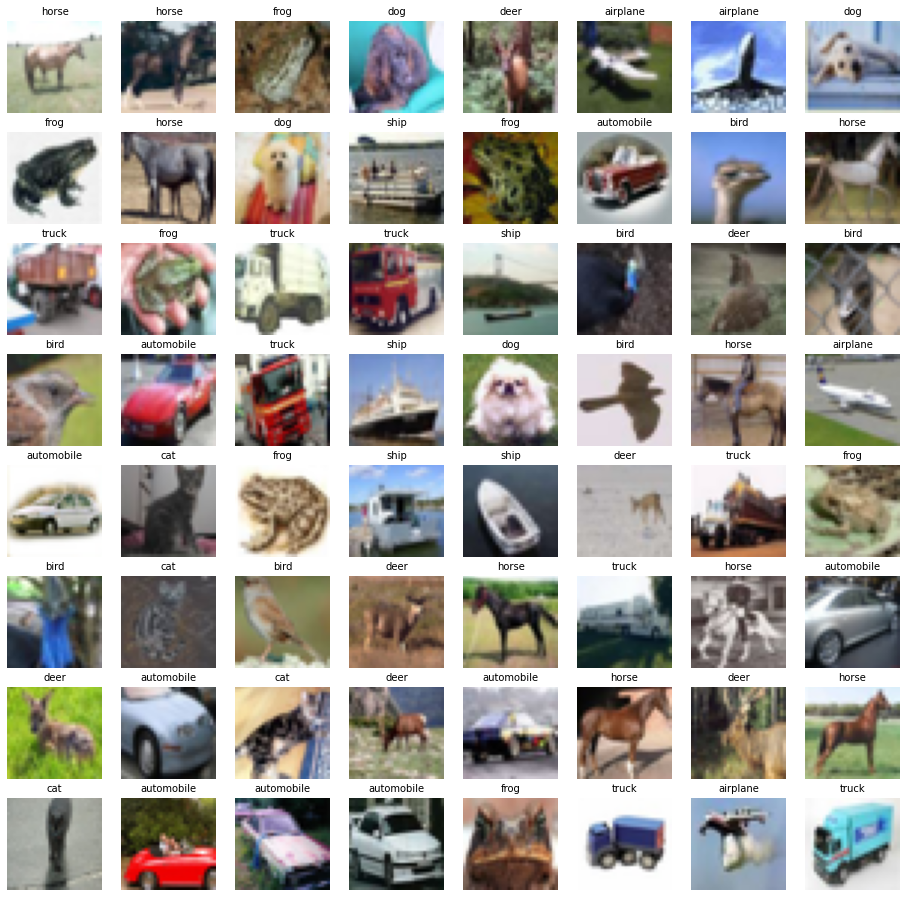

In [5]:
# Etiquetas del conjunto de datos
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Dimensiones de gradilla
w_grid = 8
l_grid = 8

fig, axes = plt.subplots(l_grid, w_grid, figsize = (16,16))
axes = axes.ravel()

n_train = len(X_train)

# Visualización de la grdilla
for i in np.arange(0, w_grid * l_grid):

    index = np.random.randint(0, n_train)
    axes[i].imshow(X_train[index,1:])
    label_index = int(y_train[index])
    axes[i].set_title(labels[label_index], fontsize=10)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.2)

## Preprocesamiento

In [6]:
type(X_train[0])

numpy.ndarray

In [7]:
X_train[0].shape

(32, 32, 3)

In [8]:
X_train.min(), X_train.max()

(0, 255)

In [9]:
X_train = X_train/255
X_val = X_val/255

In [10]:
X_train.shape, X_val.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

## Diseño de arquitectura

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout

In [46]:
model = Sequential()


model.add(Conv2D(filters=32, kernel_size=3, strides=1, input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(filters=32, kernel_size=3, strides=1, activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=1, activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=1, activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [48]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_6 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_7 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                      

# Entenamiento de Modelo

In [49]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix

In [50]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [51]:
# Aumentación de datos

batch_size = 32

data_generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = data_generator.flow(X_train, y_train, batch_size)
steps_per_epoch = X_train.shape[0] // batch_size

In [53]:
%%time
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, validation_data=(X_val, y_val), epochs=100, callbacks=[early_stop])

Epoch 1/100
1562/1562 [==============================] - 32s 20ms/step - loss: 1.3218 - accuracy: 0.5287 - val_loss: 1.0531 - val_accuracy: 0.6353
Epoch 2/100
1562/1562 [==============================] - 29s 18ms/step - loss: 1.0922 - accuracy: 0.6177 - val_loss: 0.9494 - val_accuracy: 0.6757
Epoch 3/100
1562/1562 [==============================] - 29s 19ms/step - loss: 0.9659 - accuracy: 0.6652 - val_loss: 1.0118 - val_accuracy: 0.6736
Epoch 4/100
1562/1562 [==============================] - 29s 19ms/step - loss: 0.8791 - accuracy: 0.6985 - val_loss: 0.8462 - val_accuracy: 0.7145
Epoch 5/100
1562/1562 [==============================] - 29s 19ms/step - loss: 0.8199 - accuracy: 0.7223 - val_loss: 0.7551 - val_accuracy: 0.7454
Epoch 6/100
1562/1562 [==============================] - 30s 19ms/step - loss: 0.7690 - accuracy: 0.7402 - val_loss: 0.6533 - val_accuracy: 0.7746
Epoch 7/100
1562/1562 [==============================] - 29s 18ms/step - loss: 0.7346 - accuracy: 0.7517 - val_loss: 0

In [55]:
losses = pd.DataFrame(history.history)
losses.tail()

,loss,accuracy,val_loss,val_accuracy
55,0.350143,0.879863,0.374405,0.8781
56,0.343415,0.881724,0.408558,0.8728
57,0.348784,0.881644,0.416391,0.8663
58,0.340768,0.882065,0.374645,0.8755
59,0.339415,0.883145,0.398080,0.8708


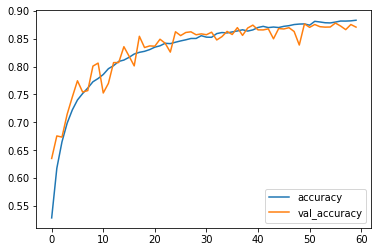

In [56]:
losses[['accuracy','val_accuracy']].plot();

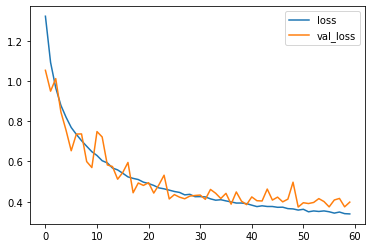

In [57]:
losses[['loss','val_loss']].plot();

In [58]:
print(model.metrics_names)
print(model.evaluate(X_val, y_val, verbose=0))

['loss', 'accuracy']
[0.3980799913406372, 0.8708000183105469]


In [59]:
predictions = model.predict(X_val)
predictions = np.argmax(predictions, axis=1).reshape(len(X_val), 1)

313/313 [==============================] - 1s 2ms/step


In [60]:
y_val.shape, predictions.shape

((10000, 1), (10000, 1))

In [61]:
# Reporte de clasficación
print(classification_report(y_val, predictions))

              precision    recall  f1-score   support

           0       0.89      0.86      0.88      1000
           1       0.93      0.95      0.94      1000
           2       0.90      0.77      0.83      1000
           3       0.73      0.79      0.76      1000
           4       0.83      0.88      0.85      1000
           5       0.87      0.74      0.80      1000
           6       0.80      0.96      0.87      1000
           7       0.95      0.88      0.92      1000
           8       0.94      0.93      0.94      1000
           9       0.91      0.95      0.93      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



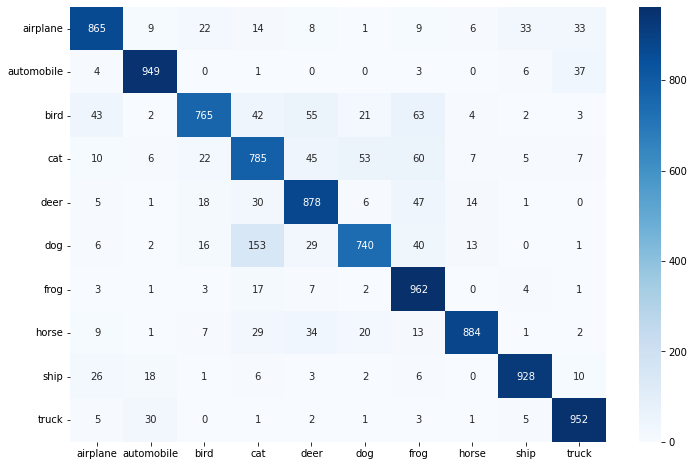

In [65]:
# Matriz de confusión
plt.figure(figsize=(12,8))
sns.heatmap(confusion_matrix(y_val, predictions), annot=True, cmap="Blues",
            fmt=".3g", xticklabels=labels, yticklabels=labels);

### Predicciones del modelo

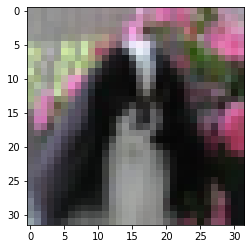

In [81]:
idx = 42  # Probar con diferentes índices
my_image = X_val[idx]
plt.imshow(my_image);

In [89]:
# Real contra predicho
for idx in range(20):
    my_image = X_val[idx]

    real = labels[y_val[idx][0]]
    pred = labels[np.argmax(model.predict(my_image.reshape(1, 32, 32, 3)))]

    print(f"[INFO] Real: {real}")
    print(f"[INFO] Predicho: {pred}\n")

1/1 [==============================] - 0s 26ms/step
[INFO] Real: cat
[INFO] Predicho: cat

1/1 [==============================] - 0s 25ms/step
[INFO] Real: ship
[INFO] Predicho: ship

1/1 [==============================] - 0s 25ms/step
[INFO] Real: ship
[INFO] Predicho: automobile

1/1 [==============================] - 0s 23ms/step
[INFO] Real: airplane
[INFO] Predicho: ship

1/1 [==============================] - 0s 25ms/step
[INFO] Real: frog
[INFO] Predicho: frog

1/1 [==============================] - 0s 27ms/step
[INFO] Real: frog
[INFO] Predicho: frog

1/1 [==============================] - 0s 18ms/step
[INFO] Real: automobile
[INFO] Predicho: automobile

1/1 [==============================] - 0s 20ms/step
[INFO] Real: frog
[INFO] Predicho: frog

1/1 [==============================] - 0s 16ms/step
[INFO] Real: cat
[INFO] Predicho: cat

1/1 [==============================] - 0s 14ms/step
[INFO] Real: automobile
[INFO] Predicho: automobile

1/1 [==============================] - 0